In [46]:
import os
import io
import unicodedata
import string
import glob
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [47]:
ALL_LETTERS = string.ascii_letters + '.,;'
N_LETTERS = len(ALL_LETTERS)

In [48]:
# Turn a unicode string to plain ASCII

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

In [49]:
def load_data():
    # Build category lines dictonary, a list of names per langauge
    category_lines ={}
    all_categories = []
    def find_files(path):
        return glob.glob(path)
    def read_lines(filename):
        lines = io.open(filename, encoding = 'utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]
    for filename in find_files('names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        lines = read_lines(filename)
        category_lines[category] = lines
    return category_lines, all_categories

In [50]:
# Find letter index in all letters
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor
    
# Turn a line into a tensor of <1 x N_LETTERS>
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] =1
    return tensor
def random_training_example(category_lines, all_categories):
    def random_choice(a):
        random_idx = torch.randint(0, len(a), (1,)).item()
        return a[random_idx]
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype = torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

In [51]:
# print(unicode_to_ascii("Héllo, ça va?"))
# category_lines, all_categories = load_data()
# print(category_lines['German'][1])
# print(line_to_tensor(category_lines['German'][1]))

In [53]:
category_lines, all_categories = load_data()
n_categories = len(all_categories)
n_categories

18

In [54]:
n_hidden = 128

In [68]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim= 1)
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [69]:
rnn = RNN(
    input_size= N_LETTERS,
    hidden_size=n_hidden,
    output_size=n_categories,
)

In [70]:
# One step
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()
output, next_hidden = rnn(input_tensor, hidden_tensor)
print(output.shape)
print(next_hidden.shape)

torch.Size([1, 18])
torch.Size([1, 128])


In [71]:
# Whole sequence / Name

input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()
output, next_hidden = rnn(input_tensor[0], hidden_tensor)
print(output.shape)
print(next_hidden.shape)

torch.Size([1, 18])
torch.Size([1, 128])


In [72]:
def category_from_output(output, all_categories = all_categories):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

In [73]:
print(category_from_output(output))

Russian


In [74]:
# Train RNN
criterion = nn.NLLLoss()
lr = 0.001
optimizer = torch.optim.SGD(rnn.parameters(),lr= lr)

In [75]:
def train_model(line_tensor, category_tensor):
    hidden = rnn.init_hidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(
            line_tensor[i],
            hidden
        )
    loss = criterion(output, category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return output, loss.item()

4999 4.999 2.9345 Azarola / Portuguese WRONG: (Spanish)
9999 9.998999999999999 2.9083 Baik / Irish WRONG: (Korean)
14999 14.999 2.8729 Ha / Japanese WRONG: (Vietnamese)
19999 19.999 2.7168 Woo / Portuguese WRONG: (Korean)
24999 24.999 2.8989 Manus / Portuguese WRONG: (Irish)
29999 29.999 1.5408 Bing / Chinese CORRECT
34999 34.999 0.4594 Theofilopoulos / Greek CORRECT
39999 39.999 1.9043 Coelho / Portuguese CORRECT
44999 44.999 1.7073 Kalachihin / Russian CORRECT
49999 49.999 1.6204 Ho / Korean WRONG: (Vietnamese)
54999 54.998999999999995 1.8013 Ton / Korean WRONG: (Vietnamese)
59999 59.999 2.4208 Trucco / Portuguese WRONG: (Italian)
64999 64.999 2.4909 Adkins / Japanese WRONG: (English)
69999 69.999 3.2476 Gaspar / Arabic WRONG: (Portuguese)
74999 74.99900000000001 1.4206 Sneijers / Dutch CORRECT
79999 79.999 2.1694 Laren / Spanish WRONG: (Dutch)
84999 84.999 3.3938 Marqueringh / Irish WRONG: (Dutch)
89999 89.999 2.4810 David / Arabic WRONG: (French)
94999 94.999 1.0443 Jamieson / Scot

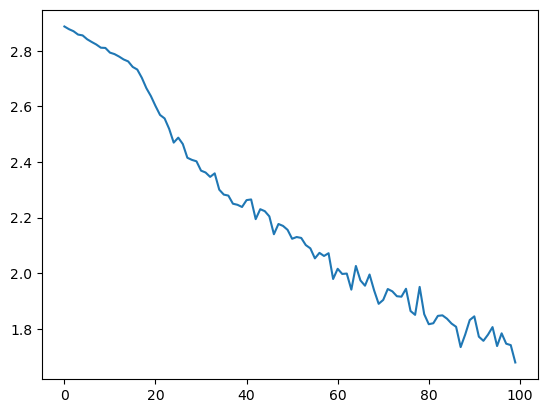

In [76]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    output, loss = train_model(line_tensor, category_tensor)
    current_loss += loss
    if (i + 1) % plot_steps == 0:
        all_losses.append(current_loss/plot_steps)
        current_loss = 0
    if (i + 1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG: ({category})"
        print(f"{i} {i/n_iters* 100} {loss:.4f} {line} / {guess} {correct}")
plt.figure()
plt.plot(all_losses)
plt.show()

In [77]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.inference_mode():
        line_tensor = line_to_tensor(input_line)
        hidden = rnn.init_hidden()
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(
                line_tensor[i],
                hidden)
        guess = category_from_output(output)
        print(guess)
        
            

In [78]:
while True:
    sentence = input("Input:")
    if sentence == "quit":
        break
    predict(sentence)

Input: quit
